In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import squarify 

import statistics
from scipy.stats import t
from scipy.stats import norm
from scipy import stats

from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import chi2_contingency

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


import io
import requests
from IPython.display import Image

%matplotlib inline

### 1. Загрузить файл hr.csv ###

In [2]:
url='hr.csv'
dataset=pd.read_csv(url)

In [3]:
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
# для удобства sales в department
dataset.rename(columns={'sales': 'department'}, inplace=True)

In [5]:
# количество строк и столбцов
dataset.shape

(14999, 10)

In [6]:
# типы данных
dataset.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

In [7]:
dataset.department = dataset.department.astype('category')
dataset.salary = dataset.salary.astype('category')

In [8]:
# дублирую и кодирую "категорийные" столбцы 
dataset['int_department'] = dataset.department
dataset['int_salary'] = dataset.salary

dataset.int_department.sort_values()
le = LabelEncoder()
dataset['int_department'] = le.fit_transform(dataset['int_department']) + 1

dataset.int_salary.sort_values()
dataset['int_salary'] = le.fit_transform(dataset['int_salary']) + 1

# меняю местами
dataset = dataset[[
    'satisfaction_level', 'last_evaluation', 'number_project',
    'average_montly_hours', 'time_spend_company', 'Work_accident',
    'left', 'promotion_last_5years', 'int_department', 'int_salary', 'department', 'salary']]

**Проверка на выбросы**

In [9]:
# проверка на пустые значения
dataset.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
int_department           0
int_salary               0
department               0
salary                   0
dtype: int64

In [10]:
# "проверяю на бинарность" показатели 5-7 (хотя это видно на гистограммах):
for i in dataset.iloc[:,5:8]:
    print(dataset[i].value_counts())

0    12830
1     2169
Name: Work_accident, dtype: int64
0    11428
1     3571
Name: left, dtype: int64
0    14680
1      319
Name: promotion_last_5years, dtype: int64


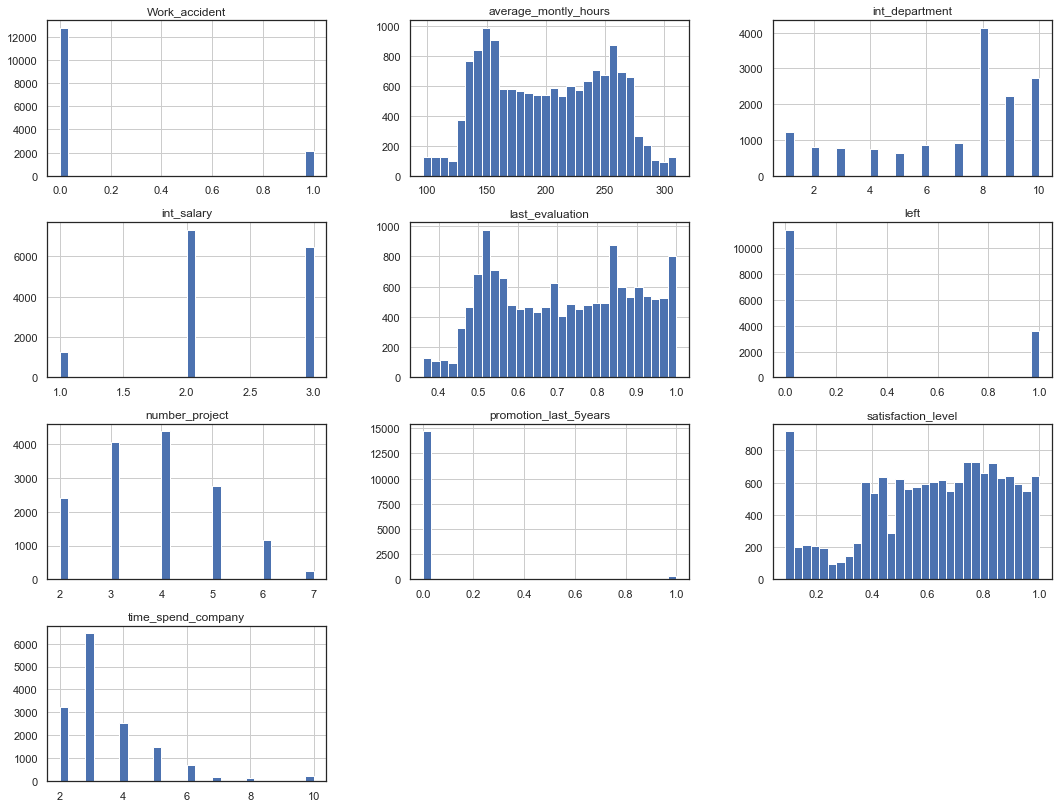

In [11]:
# Гистограммы "для знакомства"
dataset.hist(bins=30, figsize=(18,14))
plt.show()

Несмотря на хаотичный вывод графиков, бросается в глаза показатель promotion_last_5years. Первая гипотеза, почему люди уходят из компании напрашивается сама собой.

In [12]:
# Проверяю нормальное распредления с помощью Шапиро-Вилко (его нигде нет)

for i in range(10):
    test = dataset.iloc[:,i].sample(5000)
    
    alpha = 0.05
    stat, p = shapiro(test)
    print(i+1, ': ', end='')

    if p > alpha:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')

1 : Probably not Gaussian
2 : Probably not Gaussian
3 : Probably not Gaussian
4 : Probably not Gaussian
5 : Probably not Gaussian
6 : Probably not Gaussian
7 : Probably not Gaussian
8 : Probably not Gaussian
9 : Probably not Gaussian
10 : Probably not Gaussian


In [13]:
# нормализация (на всякий случай)

headers = list(dataset.iloc[:,:10].columns.values)

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,2))
np_scaled = min_max_scaler.fit_transform(dataset.iloc[:,:10])
dataset_norm = pd.DataFrame(np_scaled)
dataset_norm.columns = headers
dataset_norm.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,int_department,int_salary
0,1.318681,1.265625,1.0,1.285047,1.125,1.0,2.0,1.0,1.777778,1.5
1,1.780220,1.781250,1.6,1.775701,1.500,1.0,2.0,1.0,1.777778,2.0
2,1.021978,1.812500,2.0,1.822430,1.250,1.0,2.0,1.0,1.777778,2.0
3,1.692308,1.796875,1.6,1.593458,1.375,1.0,2.0,1.0,1.777778,1.5
4,1.307692,1.250000,1.0,1.294393,1.125,1.0,2.0,1.0,1.777778,1.5


### 2. Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред.отклонение). ###

In [14]:
# дополнение к стандартной функции (медиана = 50%)

def count_basic_stat(df):
    basic_stat = df.describe()
    
    for i in df:
        try:
            basic_stat.loc['moda',i] = statistics.mode(df[i])
                
        except:
            basic_stat.loc['moda',i] = 'Моды нет'
            
    return basic_stat

In [15]:
# базовые статистики для первых 5 столбцов
count_basic_stat(dataset.iloc[:,:5])

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
count,14999.000000,14999.000000,14999.000000,14999,14999.000000
mean,0.612834,0.716102,3.803054,201.05,3.498233
std,0.248631,0.171169,1.232592,49.9431,1.460136
min,0.090000,0.360000,2.000000,96,2.000000
25%,0.440000,0.560000,3.000000,156,3.000000
50%,0.640000,0.720000,4.000000,200,3.000000
75%,0.820000,0.870000,5.000000,245,4.000000
max,1.000000,1.000000,7.000000,310,10.000000
moda,0.100000,0.550000,4.000000,Моды нет,3.000000


Медианные значения и среднее близки, заметных выбросов нет.

Обращает внимание time_spend_company (стаж), большинство работников 3-4 года в компании.

In [16]:
# базовые статистики для 6-10 столбцов
count_basic_stat(dataset.iloc[:, 5:10])

,Work_accident,left,promotion_last_5years,int_department,int_salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.144610,0.238083,0.021268,6.870525,2.347290
std,0.351719,0.425924,0.144281,2.868786,0.625819
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,5.000000,2.000000
50%,0.000000,0.000000,0.000000,8.000000,2.000000
75%,0.000000,0.000000,0.000000,9.000000,3.000000
max,1.000000,1.000000,1.000000,10.000000,3.000000
moda,0.000000,0.000000,0.000000,8.000000,2.000000


В принципе, эти статистики не нужны. Все, что можно выжать, было видно уже на гистограмме:
- больше всего работников в 7 отделе (отделе продаж)
- большинство получает среднюю зарплату
- подозрительно близкие средние значения столбцов left и promotion_last_5years

### 3. Рассчитать и визуализировать корреляционную матрицу для переменных ###

In [17]:
corr_matrix = dataset.corr()
corr_matrix

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,int_department,int_salary
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605,0.003153,0.011754
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684,0.007772,0.013965
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064,0.009268,0.009672
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544,0.003913,0.007082
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433,-0.018010,-0.003086
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245,0.003425,-0.002506
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788,0.032105,-0.001294
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000,-0.027336,-0.001318
int_department,0.003153,0.007772,0.009268,0.003913,-0.018010,0.003425,0.032105,-0.027336,1.000000,0.000685
int_salary,0.011754,0.013965,0.009672,0.007082,-0.003086,-0.002506,-0.001294,-0.001318,0.000685,1.000000


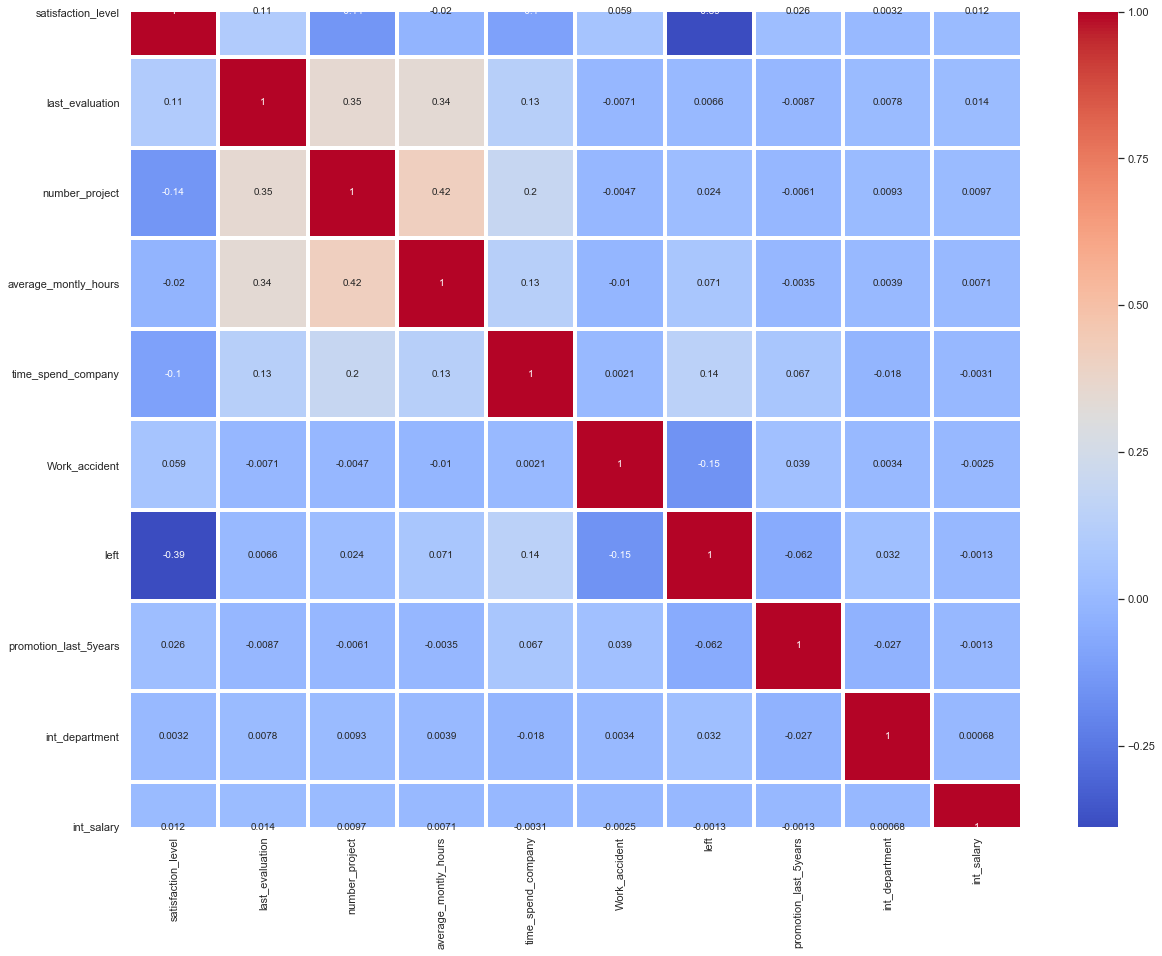

In [18]:
# оригинальный датасет
sns.heatmap(
    corr_matrix,
    annot=True, cmap='coolwarm', linewidths=3.0,
    xticklabels=corr_matrix.columns.values, yticklabels=corr_matrix.columns.values
)

fig=plt.gcf()
fig.set_size_inches(20,15)
plt.show()

Видно слабую корреляцию между временем количеством рабочих часов в месяц и количеством проектов и обратную корреляцию между удовлетворенностью работой и количеством уволившихся/уволенных.

### 4. Визуализировать несколько взаимосвязей между переменными. ###

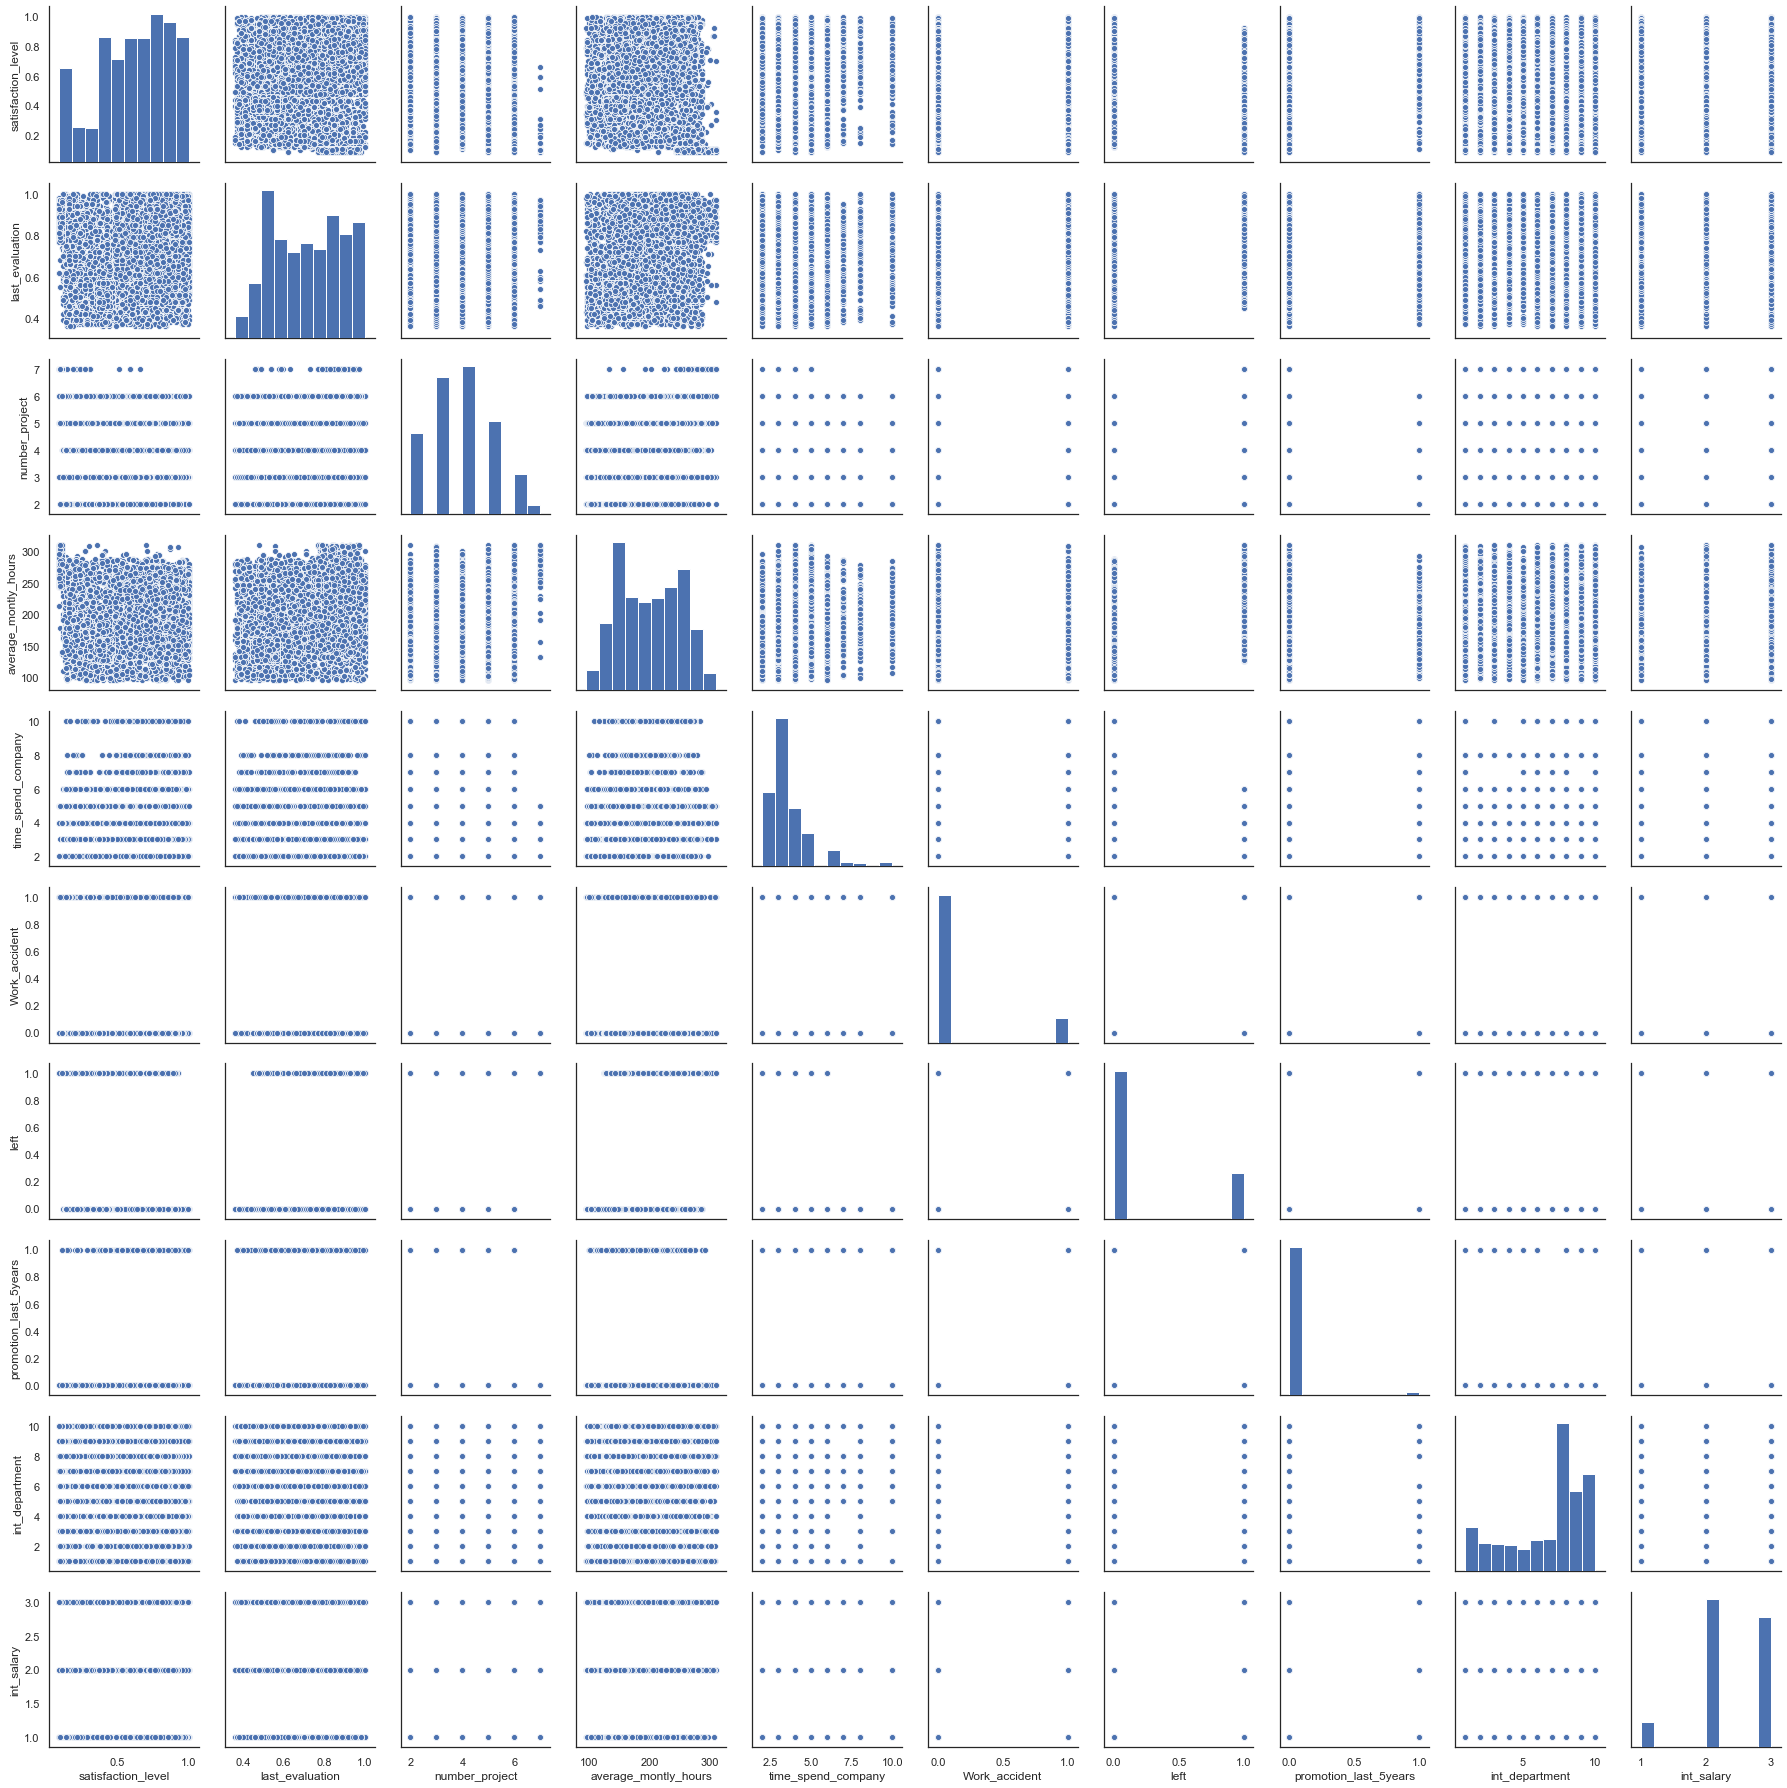

In [19]:
# парный график для всего датасета

sns.pairplot(dataset.iloc[:,:10])

In [20]:
# средние значения для графиков
time_mean = dataset.groupby('time_spend_company').mean().reset_index()

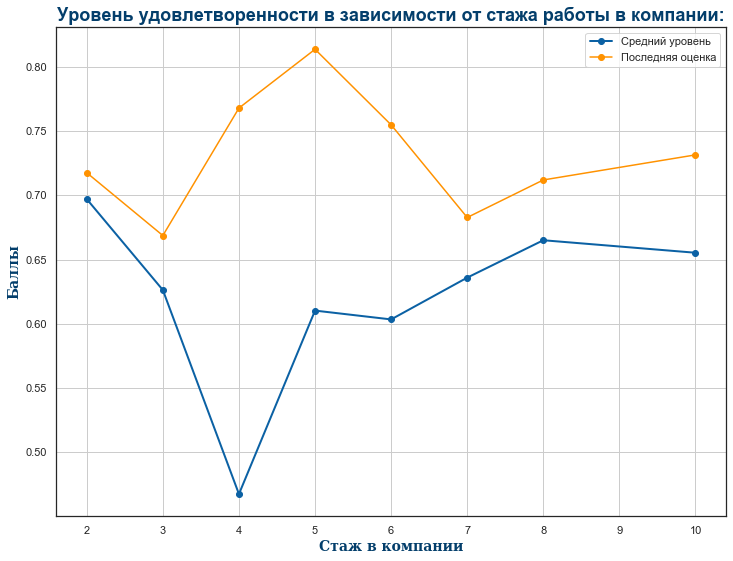

In [21]:
# уровень удовлетворенности и стаж в компании (средние значения)

plt.rcParams['figure.figsize']=(12,9)

fig, ax = plt.subplots()

plt.plot(time_mean.time_spend_company, time_mean.satisfaction_level,
         linewidth = 2,
         color = '#0B61A4',
         marker = 'o',
         label = 'Средний уровень'
        )

plt.plot(time_mean.time_spend_company, time_mean.last_evaluation,
         color = '#FF9200',
         marker = 'o',
         label = 'Последняя оценка'
        )

ax.legend()

ax.set_xlabel('Стаж в компании',
             fontfamily = 'serif',
             fontsize = 14,
             weight = 600,
             color = '#033E6B'
             )

ax.set_ylabel('Баллы',
             fontfamily = 'serif',
             fontsize = 14,
             weight = 600,
             color = '#033E6B'
             )


ax.set_title('Уровень удовлетворенности в зависимости от стажа работы в компании:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')

ax.grid(True)


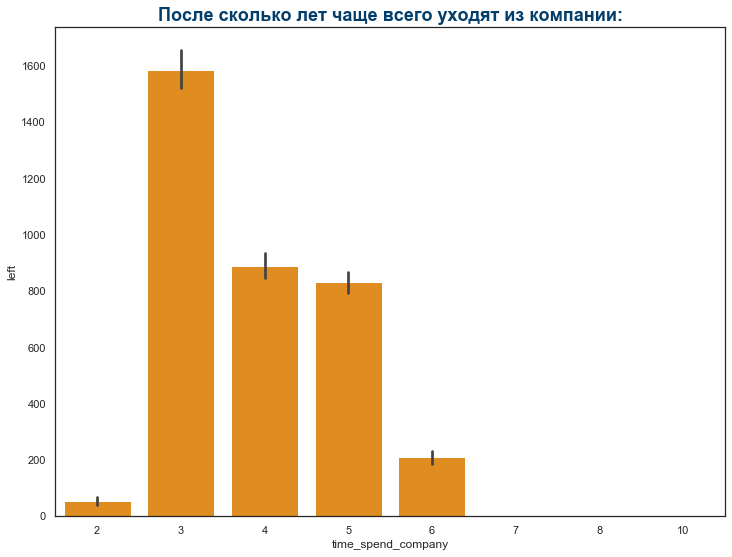

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)

sns.barplot(x=dataset.time_spend_company, y=dataset.left, estimator=sum, color = '#FF9200')


ax.set_title('После сколько лет чаще всего уходят из компании:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')
plt.show()

Объединенный график:

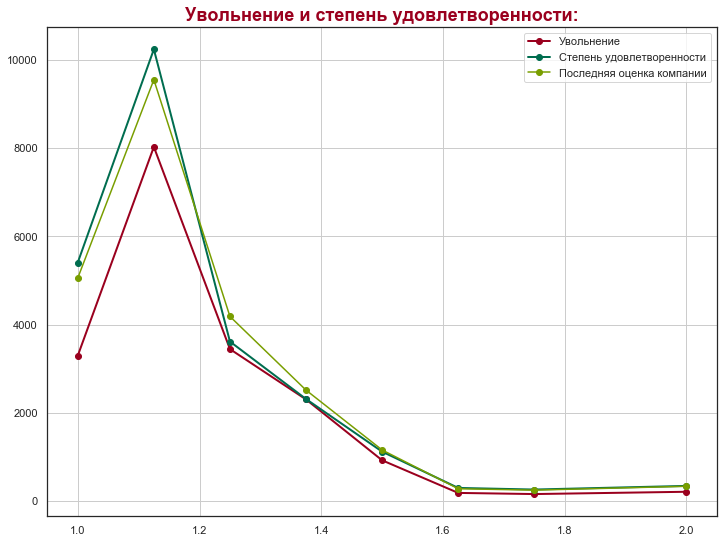

In [23]:
ntime_mean = dataset_norm.groupby('time_spend_company').sum().reset_index()

plt.rcParams['figure.figsize']=(12,9)
fig, ax = plt.subplots()


plt.plot(ntime_mean.time_spend_company, ntime_mean.left,
         linewidth = 2,
         color = '#9A001E',
         marker = 'o',
         label = 'Увольнение'
        )


plt.plot(ntime_mean.time_spend_company, ntime_mean.satisfaction_level,
         linewidth = 2,
         color = '#006D4F',
         marker = 'o',
         label = 'Степень удовлетворенности'
        )

plt.plot(ntime_mean.time_spend_company, ntime_mean.last_evaluation,
         color = '#799E00',
         marker = 'o',
         label = 'Последняя оценка компании'
        )

ax.legend()


ax.set_title('Увольнение и степень удовлетворенности:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#9A001E')

ax.grid(True)

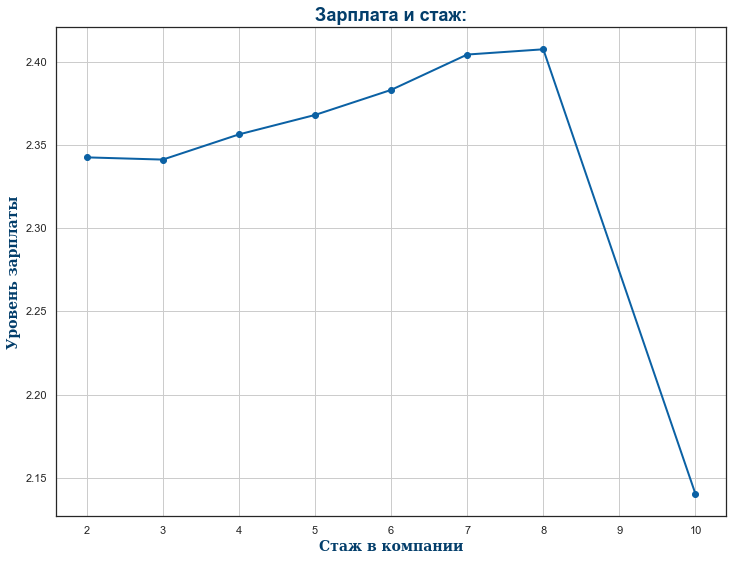

In [24]:
# Уровень зарплаты и стаж

plt.rcParams['figure.figsize']=(12,9)

fig, ax = plt.subplots()

plt.plot(time_mean.time_spend_company, time_mean.int_salary,
         linewidth = 2,
         color = '#0B61A4',
         marker = 'o',
         label = 'Средний уровень'
        )

ax.set_xlabel('Стаж в компании',
             fontfamily = 'serif',
             fontsize = 14,
             weight = 600,
             color = '#033E6B'
             )

ax.set_ylabel('Уровень зарплаты',
             fontfamily = 'serif',
             fontsize = 14,
             weight = 600,
             color = '#033E6B'
             )


ax.set_title('Зарплата и стаж:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')

ax.grid(True)

Здесь ничего неожиданного, зарплата растет со стажем. Резкий спад после 7 года обусловлен количеством работников-"старожилов".

In [25]:
# Количество работников по стажу
dataset.time_spend_company.value_counts().sort_values(ascending=False)


3     6443
2     3244
4     2557
5     1473
6      718
10     214
7      188
8      162
Name: time_spend_company, dtype: int64

**Удовлетворенность работой и уровень зарплаты:**

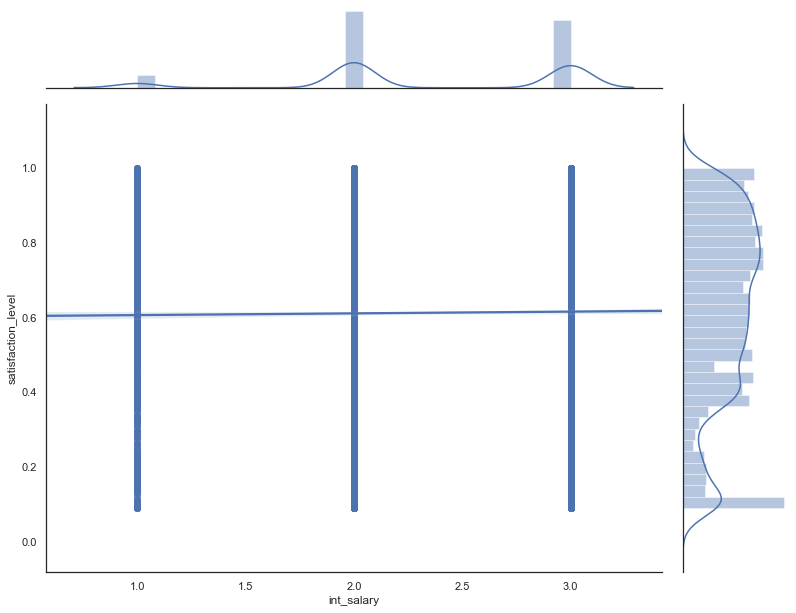

In [26]:
sns.jointplot(y='satisfaction_level', x='int_salary', data=dataset, kind='reg')
fig=plt.gcf()
fig.set_size_inches(12,9)
plt.show()

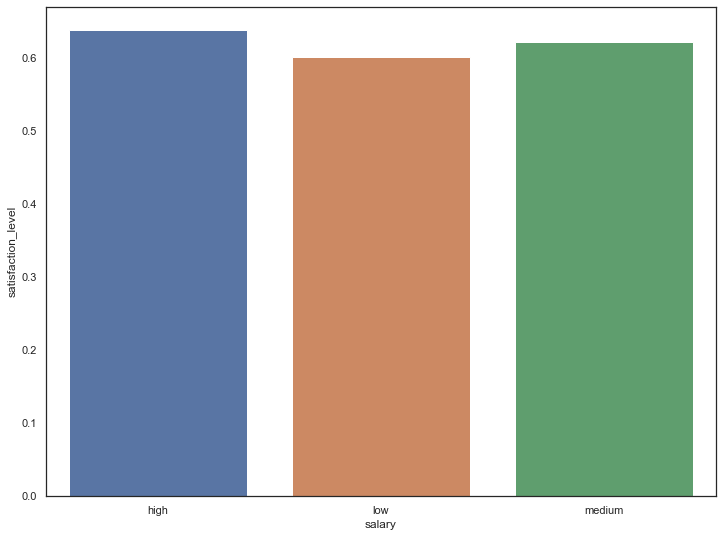

In [27]:
salary_level = dataset.groupby('salary').mean().reset_index()

sns.barplot(x=salary_level.salary, y=salary_level.satisfaction_level)
fig=plt.gcf()
fig.set_size_inches(12,9)
plt.show()

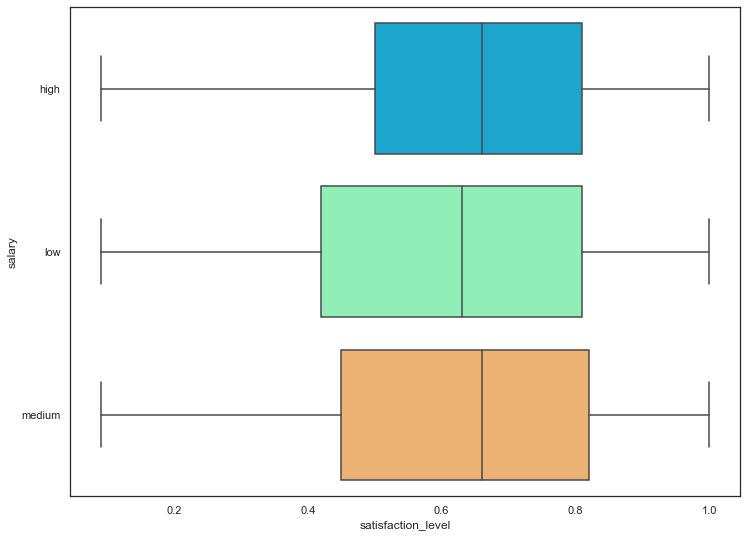

In [28]:
sns.boxplot(x='satisfaction_level', y='salary', data=dataset, palette='rainbow')

Визуально различия небольшие, но такой вывод противоречит "обычной" логике. Поэтому напрашивается дополнительная проверка.

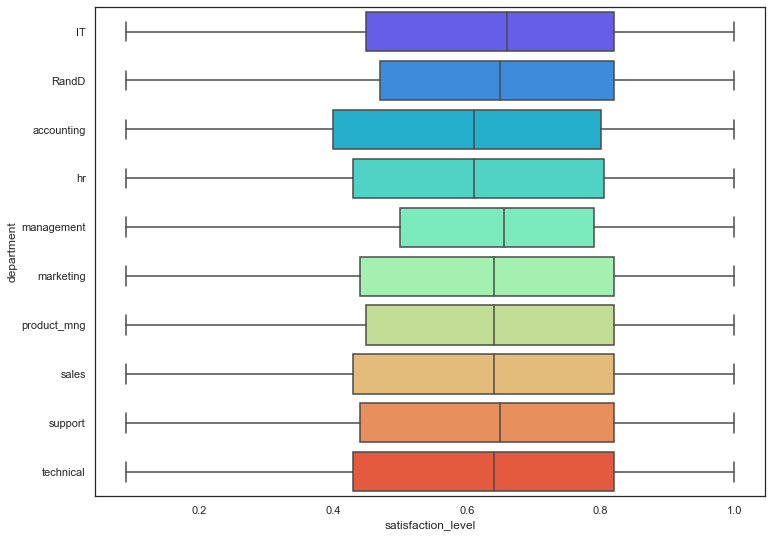

In [29]:
# уровень удовлетворенности по отделам

sns.boxplot(x='satisfaction_level', y='department', data=dataset, palette='rainbow')

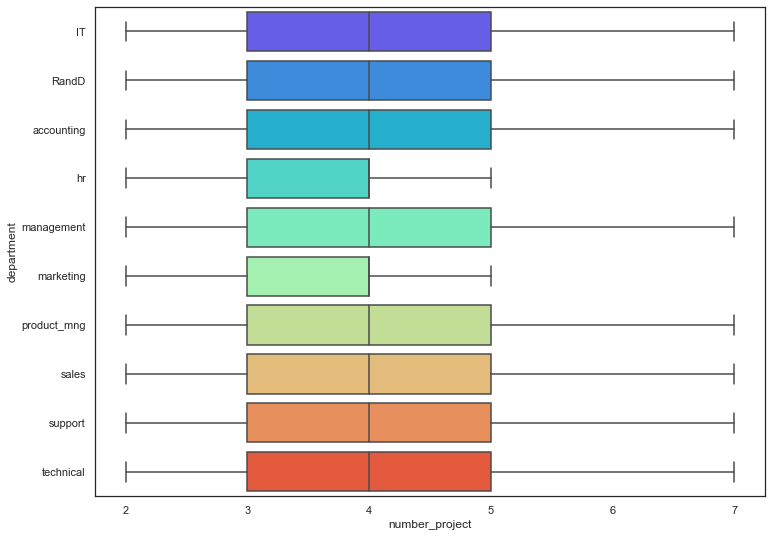

In [30]:
# количество проектов по отделам

sns.boxplot(x='number_project', y='department', data=dataset, palette='rainbow', showfliers=False)

### 5. С использованием t-test статистики проверить взаимосвязи между несколькими переменными. ###

### Гипотеза 1: размер зарплаты не влияет на то, довольны сотрудники или нет работой в компании. ### 

**Нулевая гипотеза:**  выборки по уровню зарплаты будут близки

*Распределение во всех трех случаях (гипотезах) не нормальное, не проходят ни Шапиро-Вилко, ни другие тесты.*

*Поэтому на всякий случай, добавил тест Манна-Уитни.*

In [31]:
# выделяю satisfaction_level по уровню зп

satisfaction_salary_low = dataset[dataset.salary == 'low']['satisfaction_level']
satisfaction_salary_medium = dataset[dataset.salary == 'medium']['satisfaction_level']
satisfaction_salary_high = dataset[dataset.salary == 'high']['satisfaction_level']

satisfaction_all_salary = dataset.satisfaction_level

In [32]:
print(len(satisfaction_salary_low))
print(len(satisfaction_salary_medium))
print(len(satisfaction_salary_high))

7316
6446
1237


In [33]:
# Sample 

satisfaction_salary_low = satisfaction_salary_low.sample(1237)
satisfaction_salary_medium = satisfaction_salary_medium.sample(1237)
satisfaction_salary_high = satisfaction_salary_high.sample(1237)

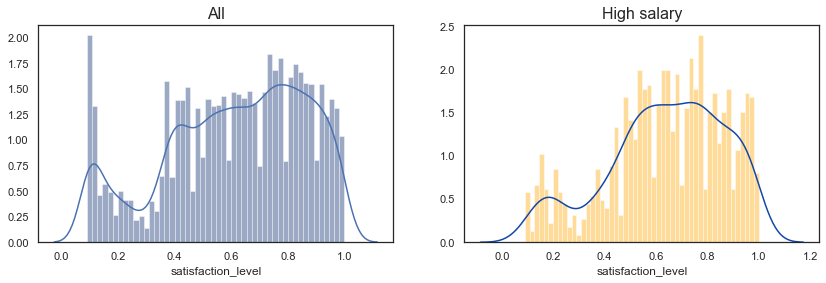

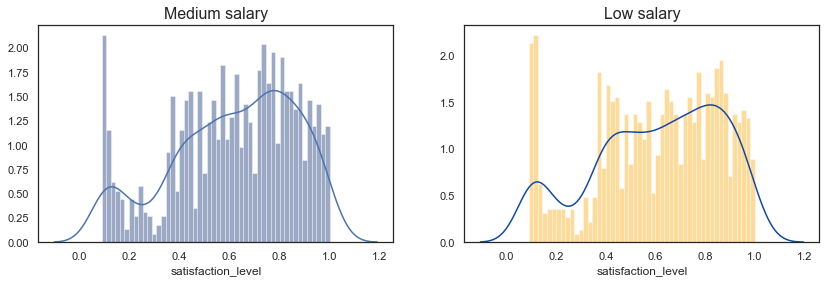

In [34]:
plt.rcParams['figure.figsize']=(14,4)
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(satisfaction_all_salary, bins=50, kde=True,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(satisfaction_salary_high, bins=50, kde=True,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('All', fontsize=16)
ax2.set_title('High salary', fontsize=16)

f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(satisfaction_salary_medium, bins=50, kde=True,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(satisfaction_salary_low, bins=50, kde=True,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('Medium salary', fontsize=16)
ax2.set_title('Low salary', fontsize=16)

plt.show()

In [35]:
# Распределение далеко от нормального

stat, p = stats.shapiro(np.log10(satisfaction_salary_medium))
p > 0.05

False

In [36]:
# тест Флигнера

stats.fligner(satisfaction_salary_low, satisfaction_salary_medium)

FlignerResult(statistic=2.263675832396812, pvalue=0.1324393707429217)

In [37]:
# Т-тест

stats.ttest_ind(satisfaction_salary_low, satisfaction_salary_medium)

Ttest_indResult(statistic=-1.1362798392115916, pvalue=0.25594960800177413)

In [38]:
# Манн-Уитни

stats.mannwhitneyu(satisfaction_salary_low, satisfaction_salary_medium)

MannwhitneyuResult(statistic=748466.0, pvalue=0.17475696571715532)

In [39]:
# Т-тест 

stats.ttest_ind(satisfaction_salary_high, satisfaction_salary_medium)

Ttest_indResult(statistic=2.2709825805709554, pvalue=0.023233690204498843)

In [40]:
# Манн-Уитни

stats.mannwhitneyu(satisfaction_salary_high, satisfaction_salary_medium)

MannwhitneyuResult(statistic=733299.5, pvalue=0.03678023828400076)

In [41]:
# Т-тест

stats.ttest_ind(satisfaction_salary_low, satisfaction_salary_high)

Ttest_indResult(statistic=-3.4103954358829722, pvalue=0.0006591015750445902)

In [42]:
# Манн-Уитни

stats.mannwhitneyu(satisfaction_salary_low, satisfaction_salary_high)

MannwhitneyuResult(statistic=715395.0, pvalue=0.0025766819240070496)

Т-тест показывает сходство средних у low и medium и отличия high salary от двух других.

Среднее satisfaction_salary_high отличается от среднего ГС (satisfaction_all_salary), T-value - 3,82 больше табличного - 1,96 (сама таблица внизу ноутбука), p-value меньше выбранного альфа-уровня - 0,05.

In [43]:
# односторонний Т-тест
stats.ttest_1samp(satisfaction_salary_high, satisfaction_all_salary.mean())

Ttest_1sampResult(statistic=3.82059975018617, pvalue=0.00013974368695866474)

**Вывод:** размер зарплаты все же имеет значение. Мы можем говорит о уровне удовлетворения работой для работников с высокой зарплатой и всех остальных.

### Гипотеза 2: время работы не связано с уровнем зарплаты. ###

**Нулевая гипотеза:** работники с разным уровнем зарплаты работают одинаковое количество часов.

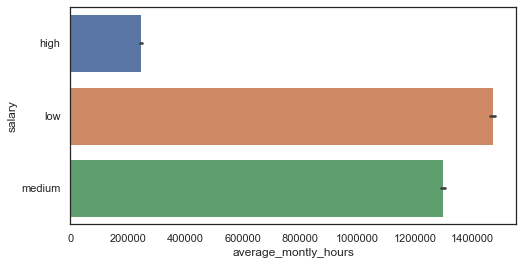

In [44]:
# общее количество часов работников по уровню зарплаты (но верить ему нельзя)

sns.barplot(x=dataset.average_montly_hours, y=dataset.salary, estimator=sum)

fig=plt.gcf()
fig.set_size_inches(8,4)
plt.show()

In [45]:
# выделяю нужные группы
hours_salary_low = dataset[dataset.salary == 'low']['average_montly_hours']
hours_salary_medium = dataset[dataset.salary == 'medium']['average_montly_hours']
hours_salary_high = dataset[dataset.salary == 'high']['average_montly_hours']

In [46]:
print(len(hours_salary_low))
print(len(hours_salary_medium))
print(len(hours_salary_high))

7316
6446
1237


In [47]:
hours_salary_low = hours_salary_low.sample(1237)
hours_salary_medium = hours_salary_medium.sample(1237)
hours_salary_high = hours_salary_high.sample(1237)

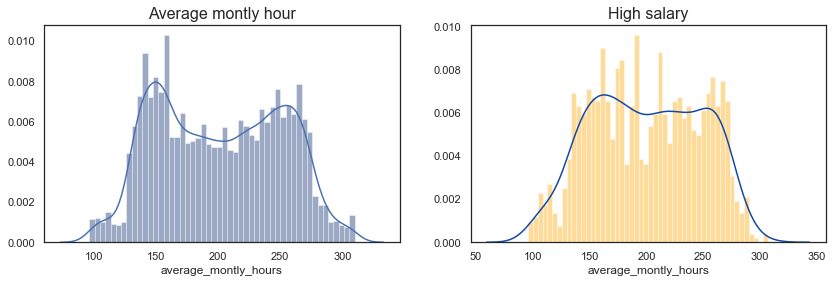

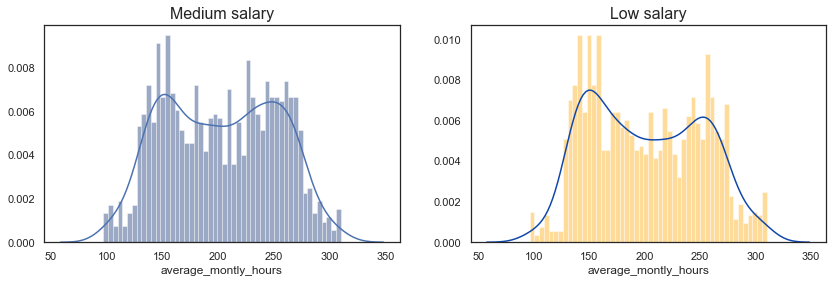

In [48]:
# на гистограммах уже виден результат

plt.rcParams['figure.figsize']=(14,4)
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(dataset.average_montly_hours, bins=50, kde=True,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(hours_salary_high, bins=50, kde=True,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
                             
ax1.set_title('Average montly hour', fontsize=16)
ax2.set_title('High salary', fontsize=16)

                             
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(hours_salary_medium, bins=50, kde=True,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(hours_salary_low, bins=50, kde=True,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
                             
ax1.set_title('Medium salary', fontsize=16)
ax2.set_title('Low salary', fontsize=16)
plt.show()

In [49]:
# Распределение далеко от нормального

stat, p = stats.shapiro(np.log10(hours_salary_low))
p > 0.05

False

In [50]:
# тест Флигнера

stats.fligner(hours_salary_low, hours_salary_high)

FlignerResult(statistic=9.962682924060553, pvalue=0.0015974509425159952)

In [51]:
# low и medium Т-Тест
stats.ttest_ind(hours_salary_low, hours_salary_medium, equal_var=False)

Ttest_indResult(statistic=-0.7232251038074229, pvalue=0.46961002969786014)

In [52]:
# low и medium Манн-Уитни

stats.mannwhitneyu(hours_salary_low, hours_salary_medium)

MannwhitneyuResult(statistic=749820.0, pvalue=0.19510580591288984)

In [53]:
# low и high Т-Тест

stats.ttest_ind(hours_salary_low, hours_salary_high, equal_var=False)

Ttest_indResult(statistic=0.3931913242516094, pvalue=0.6942122094993294)

In [54]:
# low и high Манн-Уитни

stats.ttest_ind(hours_salary_low, hours_salary_high)

Ttest_indResult(statistic=0.39319132425160935, pvalue=0.6942120825946232)

In [55]:
# medium и high Т-Тест

stats.mannwhitneyu(hours_salary_medium, hours_salary_high)

MannwhitneyuResult(statistic=749566.5, pvalue=0.19119441279646016)

In [56]:
# medium и high Манн-Уитни

stats.ttest_ind(hours_salary_medium, hours_salary_high)

Ttest_indResult(statistic=1.140686201317883, pvalue=0.2541110287324351)

Множественный тест (ANOVA) также подтверждает сходство:

In [57]:
stats.f_oneway(hours_salary_low, hours_salary_medium, hours_salary_high)

F_onewayResult(statistic=0.6549876619099297, pvalue=0.5195085601150755)

**Вывод:** принимаем нулевую гипотезу о сходстве средних.

Уровень зарплаты не зависит напрямую от количества часов, проведенных на работе.

### Гипотеза 3: карьерные успехи не зависят от количества рабочих часов. ###

**Нулевая гипотеза:** те, кто продвинулись и те, кто остались на своей должности, работают одинаковое количество часов.

In [58]:
# берем только тех, кто еще работает в компании

hours_promotion = dataset[ (dataset.promotion_last_5years == 1) & (dataset.left == 0) ]['average_montly_hours']
hours_no_promotion = dataset[ (dataset.promotion_last_5years == 0) & (dataset.left == 0) ]['average_montly_hours']

In [59]:
print(len(hours_promotion))
print(len(hours_no_promotion))

300
11128


In [60]:
hours_promotion = hours_promotion.sample(300)
hours_no_promotion = hours_no_promotion.sample(300)

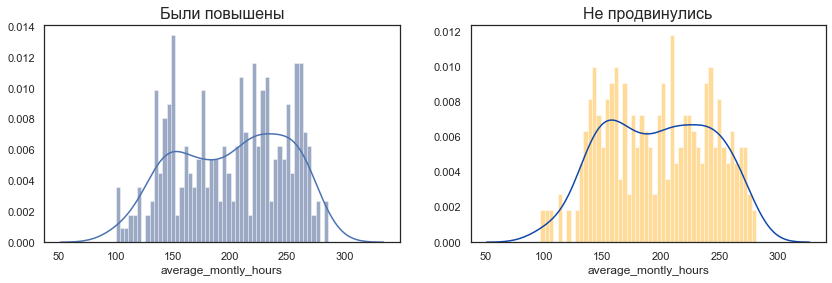

In [61]:
plt.rcParams['figure.figsize']=(14,4)
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(hours_promotion, bins=50, kde=True,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(hours_no_promotion, bins=50, kde=True,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('Были повышены', fontsize=16)
ax2.set_title('Не продвинулись', fontsize=16)
plt.show()

In [62]:
# Распределение далеко от нормального

stat, p = stats.shapiro(np.log10(hours_no_promotion))
p > 0.05

False

In [63]:
# тест Флигнера

stats.fligner(hours_promotion, hours_no_promotion)

FlignerResult(statistic=1.5899810028619294, pvalue=0.20732884800101606)

In [64]:
# Т-тест

stats.ttest_ind(hours_promotion, hours_no_promotion)

Ttest_indResult(statistic=1.085440646934089, pvalue=0.2781639087102227)

In [65]:
# Манн-Уитни

stats.mannwhitneyu(hours_promotion, hours_no_promotion)

MannwhitneyuResult(statistic=42591.0, pvalue=0.12829717800674234)

**Вывод:** принимаем нулевую гипотезу о сходстве средних.

### 6. Рассчитать сколько работников работает в каждом департаменте. ###

In [66]:
dataset.department.value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64

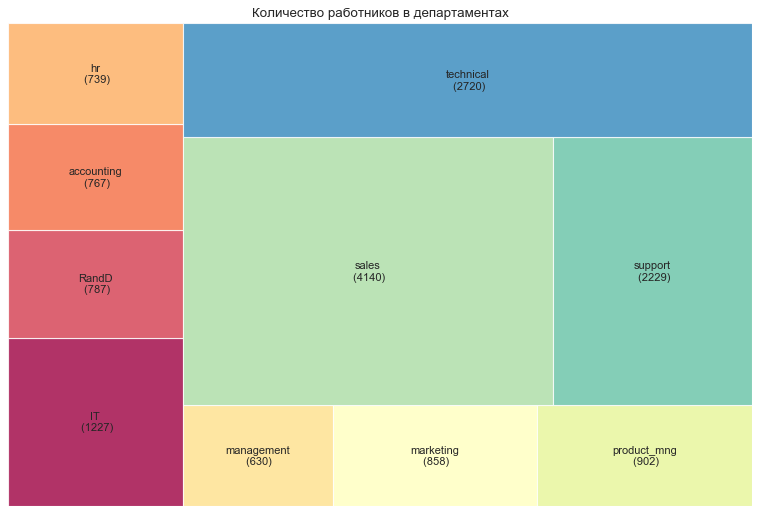

In [67]:
# Prepare Data
df = dataset.groupby('department').size().reset_index(name='counts')
labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Количество работников в департаментах')
plt.axis('off')
plt.show()

### 7. Показать распределение сотрудников по зарплатам. ###

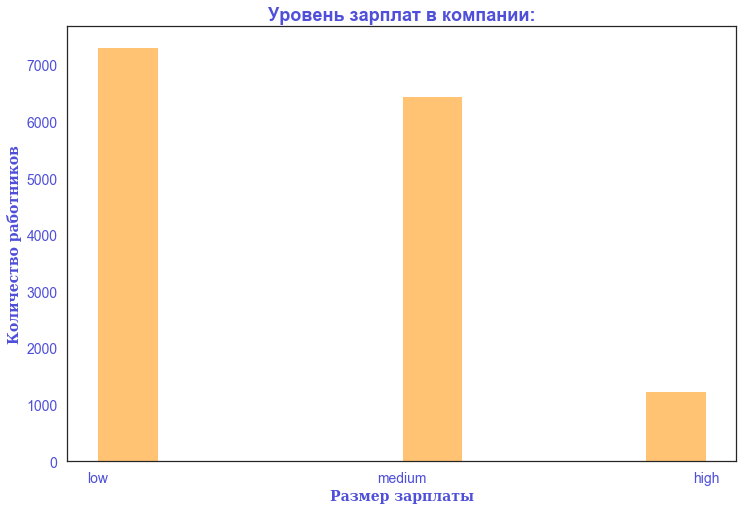

In [68]:
plt.rcParams['figure.figsize']=(12,8)

fig, ax = plt.subplots()

plt.hist(dataset.salary,
         linewidth = 1,
         color = '#FFC373',
        )

ax.set_xlabel('Размер зарплаты',
             fontfamily = 'serif',
             fontsize = 14,
             weight = 600,
             color = '#4F4FD9'
             )

ax.set_ylabel('Количество работников',
             fontfamily = 'serif',
             fontsize = 14,
             weight = 600,
             color = '#4F4FD9'
             )


ax.set_title('Уровень зарплат в компании:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#4F4FD9')

ax.tick_params(axis = 'both',
               labelsize = 14,
               labelcolor = '#4F4FD9',
    
)

plt.show()

In [69]:
dataset.salary.value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

### 8. Показать распределение сотрудников по зарплатам совместно с департаментами. ###

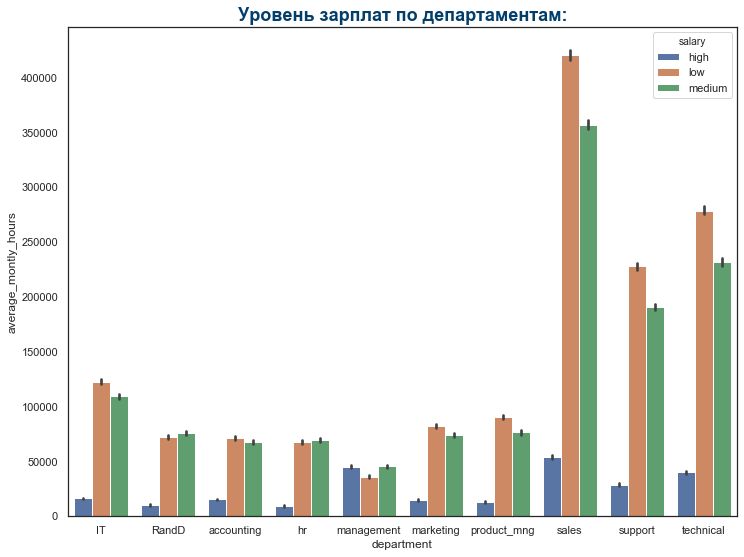

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)

sns.barplot(x=dataset.department, y=dataset.average_montly_hours, hue=dataset.salary, estimator=sum)

ax.set_title('Уровень зарплат по департаментам:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')
plt.show()


plt.show()

### 9. Сколько сотрудников покинули компанию. ###

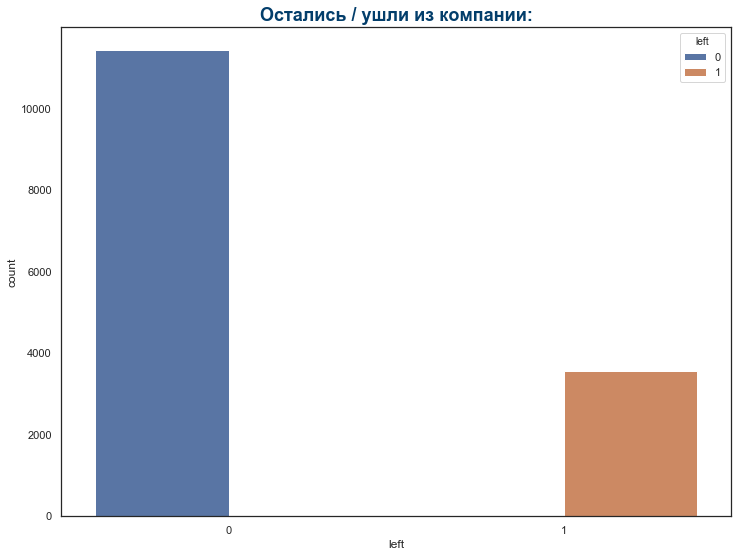

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)

sns.countplot(x=dataset.left, hue=dataset.left)

ax.set_title('Остались / ушли из компании:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')
plt.show()

In [72]:
print('Ушли из компании и уволены:', dataset.left.sum(), 'человек')

Ушли из компании и уволены: 3571 человек


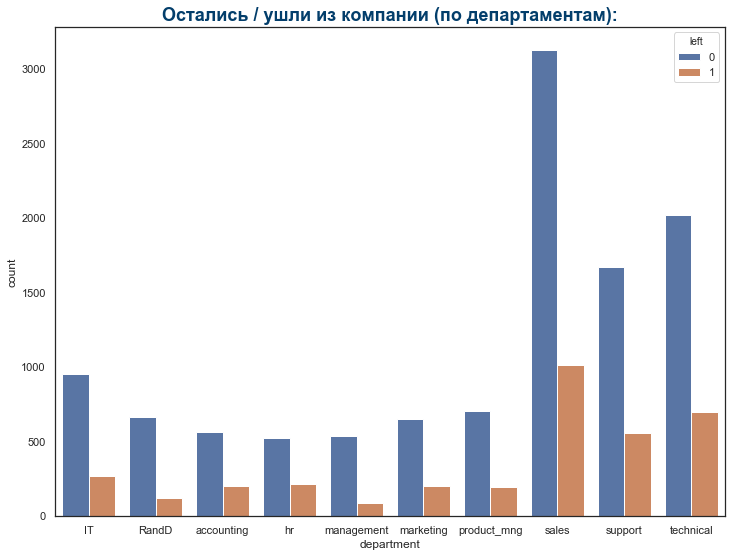

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)

sns.countplot(x=dataset.department, hue=dataset.left)

ax.set_title('Остались / ушли из компании (по департаментам):',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')
plt.show()

### 10. Проверить несколько гипотез для данных, чтобы понять почему сотрудники покидают компанию. ###

Random Forest и Classification Report:

In [74]:
# новый датасет с нужным порядком колонок

new_dataset = dataset[[
    'satisfaction_level', 'last_evaluation', 'number_project',
    'average_montly_hours', 'time_spend_company', 'promotion_last_5years', 'Work_accident',
    'int_department', 'int_salary', 'left']]

In [75]:
output_y = new_dataset.iloc[:,9:]
input_x = new_dataset.iloc[:,:9]

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(input_x, output_y, test_size=0.2)

In [77]:
# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train, Y_train)

C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

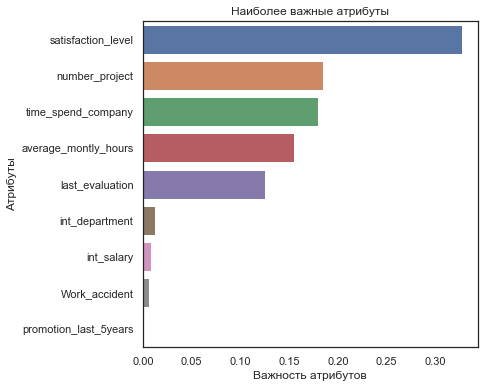

In [78]:
headers = list(X_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()

Classification report:

In [79]:
model_pred = model.predict(X_test)

print(classification_report(Y_test, model_pred))

model.score(X_test, Y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2293
           1       0.99      0.97      0.98       707

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



0.9903333333333333

### Гипотеза 1: количество проектов играет важную роль ###

**Нулевая гипотеза:** Те кто, остался и те, кто ушел, работали над одним количеством проектов.

In [80]:
# количество проектов по двум выборкам
retired = dataset[dataset.left == 1]['number_project']
current = dataset[dataset.left == 0]['number_project']

# для 3 года
retired_3 = dataset[ (dataset.left == 1) & (dataset.time_spend_company == 3) ]['number_project']
current_3 = dataset[ (dataset.left == 0) & (dataset.time_spend_company == 3) ]['number_project']

In [81]:
len(retired_3)

1586

In [82]:
current = current.sample(3571)
current_3 = current_3.sample(1586)

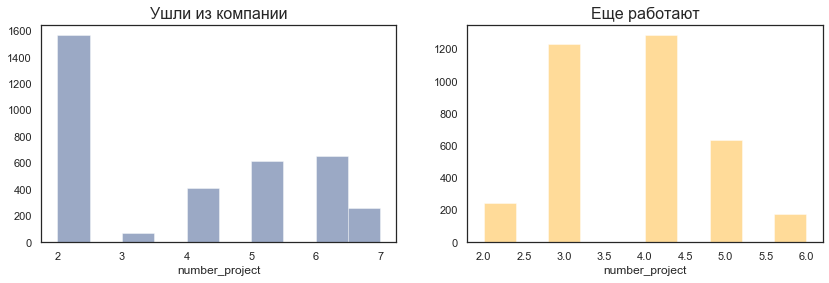

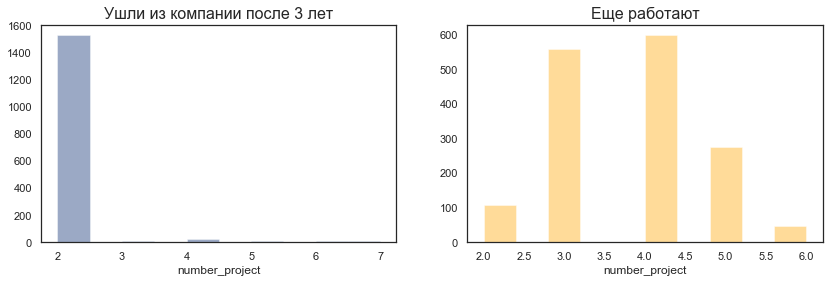

In [83]:
plt.rcParams['figure.figsize']=(14,4)
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(retired, bins=10, kde=False,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(current, bins=10, kde=False,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('Ушли из компании', fontsize=16)
ax2.set_title('Еще работают', fontsize=16)


f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(retired_3, bins=10, kde=False,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(current_3, bins=10, kde=False,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('Ушли из компании после 3 лет', fontsize=16)
ax2.set_title('Еще работают', fontsize=16)

plt.show()

In [84]:
stats.wilcoxon(retired, current)

WilcoxonResult(statistic=2391216.0, pvalue=0.07330713106750486)

In [85]:
stats.wilcoxon(retired_3, current_3)

WilcoxonResult(statistic=24711.5, pvalue=6.746802693525863e-228)

In [86]:
# дополнительные вычисления, для понимания сколько тратят времени на 1 проект

dataset['time_on_projects'] = round((dataset.average_montly_hours / dataset.time_spend_company), 2)
ntime_mean['time_on_projects'] = round((ntime_mean.average_montly_hours / ntime_mean.time_spend_company), 2)

In [87]:
time_sum = dataset.groupby('time_spend_company').sum().reset_index()

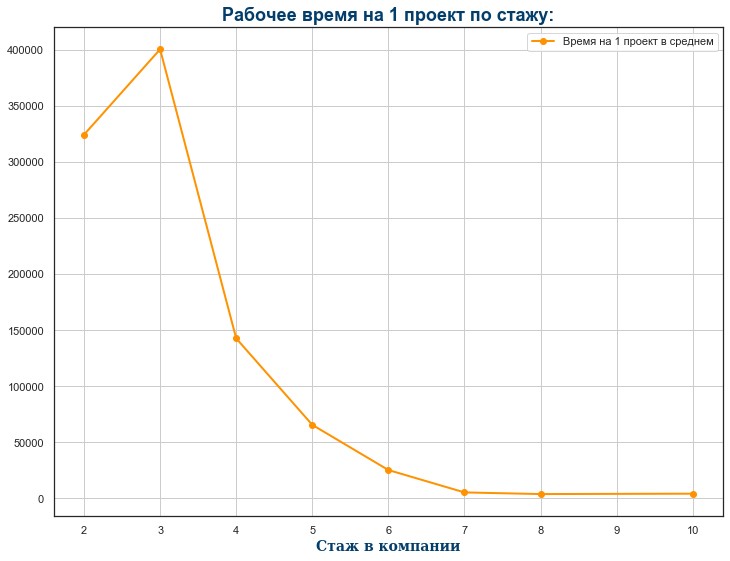

In [88]:
# суммарное время на проекты по стажу

plt.rcParams['figure.figsize']=(12,9)

fig, ax = plt.subplots()


plt.plot(time_sum.time_spend_company, time_sum.time_on_projects,
         linewidth = 2,
         color = '#FF9200',
         marker = 'o',
         label = 'Время на 1 проект в среднем'
        )

ax.set_xlabel('Стаж в компании',
             fontfamily = 'serif',
             fontsize = 14,
             weight = 600,
             color = '#033E6B'
             )

ax.legend()

ax.set_title('Рабочее время на 1 проект по стажу:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')

ax.grid(True)

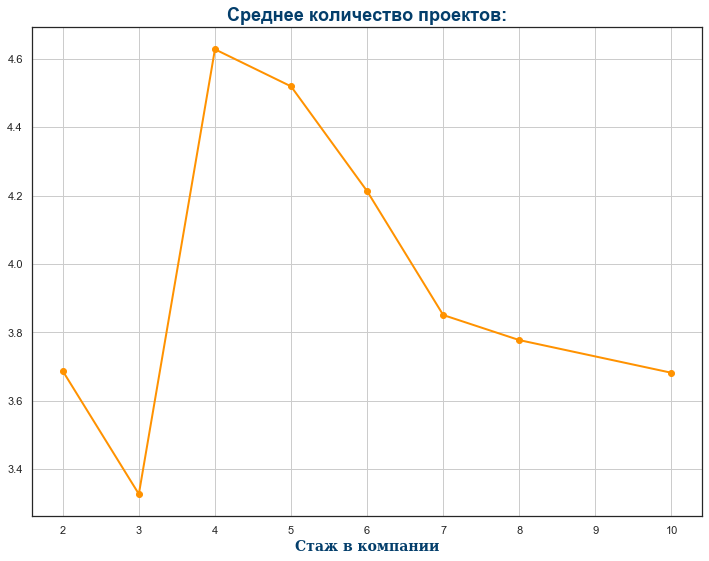

In [89]:
# количество проектов по стажу

plt.rcParams['figure.figsize']=(12,9)

fig, ax = plt.subplots()


plt.plot(time_mean.time_spend_company, time_mean.number_project,
         linewidth = 2,
         color = '#FF9200',
         marker = 'o',
        )

ax.set_xlabel('Стаж в компании',
             fontfamily = 'serif',
             fontsize = 14,
             weight = 600,
             color = '#033E6B'
             )

ax.set_title('Среднее количество проектов:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')

ax.grid(True)

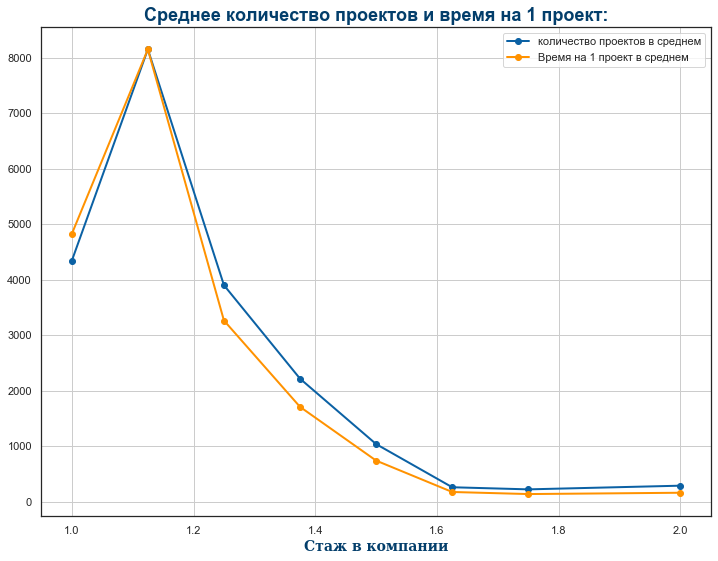

In [90]:
# среднее количество проектов  и время на 1 проект

plt.rcParams['figure.figsize']=(12,9)

fig, ax = plt.subplots()

plt.plot(ntime_mean.time_spend_company, ntime_mean.number_project,
         linewidth = 2,
         color = '#0B61A4',
         marker = 'o',
         label = 'количество проектов в среднем'
        )


plt.plot(ntime_mean.time_spend_company, ntime_mean.time_on_projects,
         linewidth = 2,
         color = '#FF9200',
         marker = 'o',
         label = 'Время на 1 проект в среднем'
        )

ax.set_xlabel('Стаж в компании',
             fontfamily = 'serif',
             fontsize = 14,
             weight = 600,
             color = '#033E6B'
             )

ax.legend()

ax.set_title('Среднее количество проектов и время на 1 проект:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')

ax.grid(True)

**Вывод:** количество проектов влияет на уход из компании.

После 3-го года работы проектов мало, время на их выполнение растет.

Есть два варианта:

 1) Работники не получают достаточного количества проектов и уходят
 
 2) Не справляются с теми проектами, что есть, и уходят, либо их увольняют

### Гипотеза 2. Зарплата не всегда имеет значение ###

**Нулевая гипотеза:** те, кто ушел будут иметь такое же распределение по ЗП, что и все вместе взятые.

Распределение не нормальное, выборки зависимые, используем критерий Вилкоксона.

In [91]:
# количество проектов по двум выборкам
retired_salary = dataset[dataset.left == 1]['int_salary']
current_salary = dataset[dataset.left == 0]['int_salary']
all_salary = dataset['int_salary']


# для 3 года
retired_3s = dataset[ (dataset.left == 1) & (dataset.time_spend_company == 3) ]['int_salary']
current_3s = dataset[ (dataset.left == 0) & (dataset.time_spend_company == 3) ]['int_salary']
all_3s = dataset[ (dataset.time_spend_company == 3) ]['int_salary']


# для 4 года
retired_4s = dataset[ (dataset.left == 1) & (dataset.time_spend_company == 4) ]['int_salary']
current_4s = dataset[ (dataset.left == 0) & (dataset.time_spend_company == 4) ]['int_salary']
all_4s = dataset[ (dataset.time_spend_company == 4) ]['int_salary']

In [92]:
# любой стаж

len(retired_salary)

3571

In [93]:
x = retired_salary.sample(3571)
y = all_salary.sample(3571)

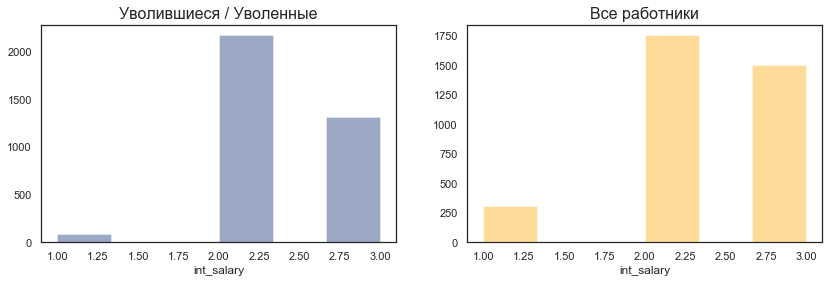

In [94]:
plt.rcParams['figure.figsize']=(14,4)
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(x, bins=6, kde=False,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(y, bins=6, kde=False,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('Уволившиеся / Уволенные', fontsize=16)
ax2.set_title('Все работники', fontsize=16)
plt.show()

In [95]:
stats.wilcoxon(x, y)

WilcoxonResult(statistic=917643.0, pvalue=0.3914683921734572)

In [96]:
# сравнение сотрудников, проработавших 3 года
len(retired_3s)

1586

In [97]:
x = retired_3s
y = all_3s.sample(1586)

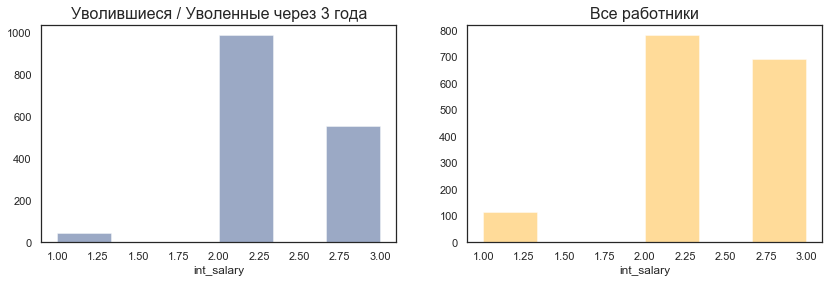

In [98]:
plt.rcParams['figure.figsize']=(14,4)
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(x, bins=6, kde=False,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(y, bins=6, kde=False,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('Уволившиеся / Уволенные через 3 года', fontsize=16)
ax2.set_title('Все работники', fontsize=16)
plt.show()

In [99]:
stats.wilcoxon(x, y)

WilcoxonResult(statistic=180564.0, pvalue=0.04335125200828822)

In [100]:
# сравнение сотрудников, проработавших 4 года

len(retired_4s)

890

In [101]:
x = retired_4s
y = all_4s.sample(890)

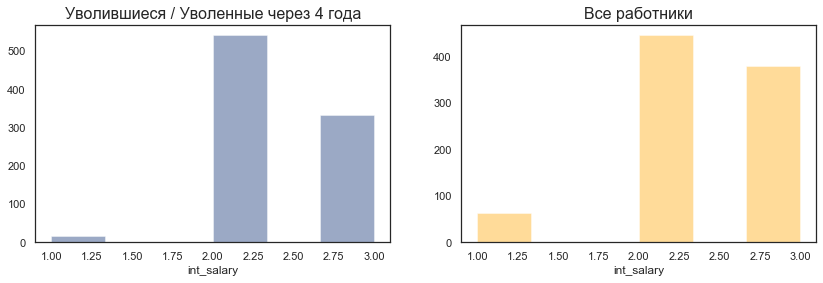

In [102]:
plt.rcParams['figure.figsize']=(14,4)
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(x, bins=6, kde=False,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(y, bins=6, kde=False,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('Уволившиеся / Уволенные через 4 года', fontsize=16)
ax2.set_title('Все работники', fontsize=16)
plt.show()

In [103]:
stats.wilcoxon(x, y)

WilcoxonResult(statistic=51919.0, pvalue=0.9430669692882526)

**Вывод:** отклонить нулевую гипотезу нельзя.


*P.S. Хотя у меня есть подозрение, что нужно использовать критерий Мак-Нимара*

### Гипотеза 3. Люди уходят, если нет движения в карьере ### 

**Нулевая гипотеза:** группы будут, тех кто продвинулся, и, кто нет, будут близки.

Распределение не нормальное, группы независимые - критерий Манна-Уитни.

*Хотя, возможно, здесь нужен Хи-квадрат*

Text(0.5, 1.0, 'Продвижение по времени работы в компании:')

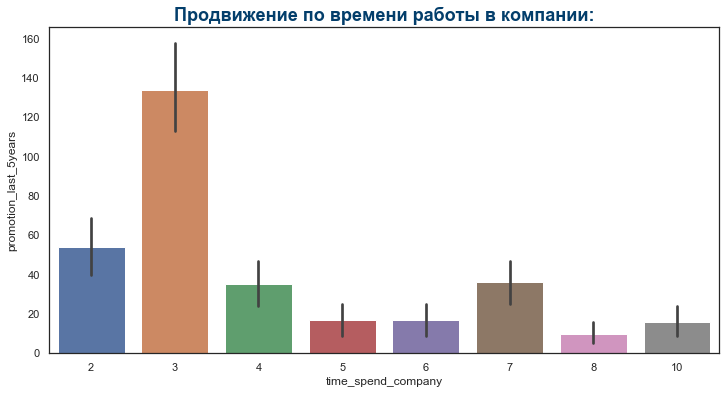

In [104]:
# количество повышений в соответствии со стажем (для общей картины)

plt.rcParams['figure.figsize']=(12,6)

fig, ax = plt.subplots()
sns.barplot(dataset.time_spend_company, dataset.promotion_last_5years, estimator=sum)

ax.set_title('Продвижение по времени работы в компании:',
             fontfamily = 'sans',
             fontsize = 18,
             weight = 600,
             color = '#033E6B')

In [105]:
# делаю выборки
prom = dataset[ (dataset.promotion_last_5years == 1) ]['left']
prom_no = dataset[ (dataset.promotion_last_5years == 0) ]['left']

prom3 = dataset[ (dataset.time_spend_company == 3) & (dataset.promotion_last_5years == 1)]['left']
prom3_no = dataset[ (dataset.time_spend_company == 3) & (dataset.promotion_last_5years == 0)]['left']

In [106]:
len(prom)

319

In [107]:
prom_no = prom_no.sample(319)

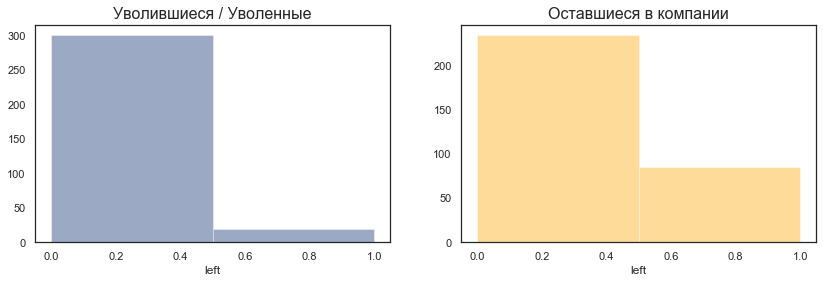

In [108]:
plt.rcParams['figure.figsize']=(14,4)
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(prom, bins=2, kde=False,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(prom_no, bins=2, kde=False,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('Уволившиеся / Уволенные', fontsize=16)
ax2.set_title('Оставшиеся в компании', fontsize=16)
plt.show()

In [109]:
stats.mannwhitneyu(prom,prom_no)

MannwhitneyuResult(statistic=40353.5, pvalue=7.850668534830316e-13)

In [110]:
# выборки после 3 года

len(prom3)

134

In [111]:
prom3_no = prom3_no.sample(134)

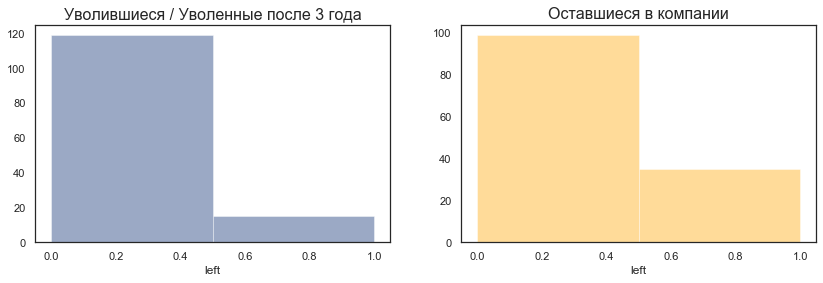

In [112]:
plt.rcParams['figure.figsize']=(14,4)
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(prom3, bins=2, kde=False,
             hist_kws={'color':'#052A6E'},
             ax=ax1
            )

sns.distplot(prom3_no, bins=2, kde=False,
             hist_kws={'color':'#FFA500'},             
             kde_kws={'color':'#1047AA'},
             ax=ax2
            )
ax1.set_title('Уволившиеся / Уволенные после 3 года', fontsize=16)
ax2.set_title('Оставшиеся в компании', fontsize=16)
plt.show()

In [113]:
stats.mannwhitneyu(prom3,prom3_no)

MannwhitneyuResult(statistic=7638.0, pvalue=0.0008769097502372266)

**Вывод:** принять нулевую гипотезу о схожести выборок нельзя. 

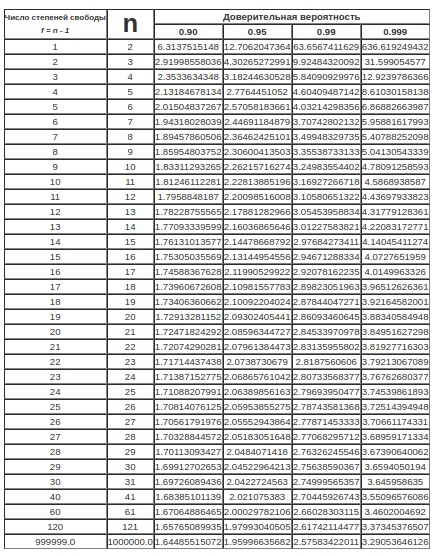

In [114]:
Image('ttest.jpg', width=600)